In [2]:
from sklearn.linear_model import ElasticNet
import joblib 
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import pandas as pd
import scipy

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

def predict_tAge(data, model):
    features = model.feature_names
    data_for_calculation = data[features]
    tAge = model.predict(data_for_calculation)
    
    return tAge

def key2key(raw, key, query_key, species):
    import mygene
    mg = mygene.MyGeneInfo()
    query = mg.querymany(raw, scopes=key, species=species, verbose=False)   

    ref2entrez = {r:[] for r in raw}
    for r, q in zip(raw, query):
        if query_key in q:
            ref2entrez[r].append(q[query_key])
        else:
            ref2entrez[r] = None

    print('Max number of ENTREZ across keys:', 
            max([len(ref2entrez[r]) for r in ref2entrez.keys() if ref2entrez[r] is not None]))

    ref2entrez = {k:v[0] for k,v in ref2entrez.items() if (v is not None) and (len(v)==1)}
    return ref2entrez

def fit_lm(sub_time, pred):
    sub_time_ = sm.add_constant(sub_time, prepend=True)
    mod = sm.OLS(pred, sub_time_)
    res = mod.fit()
    itc_m, slope_m = res.params.loc['const'], res.params.loc['Time']
    itc_p, slope_p = res.pvalues.loc['const'], res.pvalues.loc['Time']
    itc_e, slope_e = res.bse.loc['const'], res.bse.loc['Time']
    return itc_m, slope_m, itc_p, slope_p, itc_e, slope_e, res.predict()    

def starfunc(x):
    if x < 0.001:
        return '***'
    elif x < 0.01:
        return '**'
    elif x < 0.05:
        return '*'
    else:
        return ''

# Prepare data

## Mouse

In [19]:
# from utils.structure import load_structure
# udf = load_structure('data/ultradf_v4.json')

In [57]:
clocks = joblib.load(open('clocks/Aging_mouse_norm.pkl', 'rb'))
data = pd.read_csv('clocks/mouse_exprs_norm_final_29ds.csv', index_col=0)
annot = pd.read_csv('clocks/mouse_data_annotation_29ds.csv', index_col=1)


/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [58]:
mouse_clock_age_norm = predict_tAge(data, clocks)
annot['AgeNorm'] = mouse_clock_age_norm
annot = annot.drop('Unnamed: 0', 1)

/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [59]:
annot.to_csv('clocks/Mouse_clock_output.csv')

## Human

In [54]:
clocks = joblib.load(open('clocks/Aging_human_norm.pkl', 'rb'))
data = pd.read_csv('clocks/human_exprs_norm_final.csv', index_col=0)
annot = pd.read_csv('clocks/human_data_annotation.csv', index_col=1)


/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator ElasticNet from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [55]:
human_clock_age_norm = predict_tAge(data, clocks)
annot['AgeNorm'] = human_clock_age_norm
annot = annot.drop('Unnamed: 0', 1)

/home/shappiron/anaconda3/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [56]:
annot.to_csv('clocks/Human_clock_output.csv')

# Explore clocks

In [5]:
#pd.DataFrame(index=model.feature_names).to_csv('clocks/mouse_model_features.csv')
#pd.DataFrame(model.coef_, index=model.feature_names).to_csv('clocks/mouse_model_weights.csv')

In [3]:
#we upload all the data
# species = 'mouse'
model = joblib.load(open('clocks/final/Aging_mouse_norm.pkl', 'rb'))
# data = pd.read_csv('clocks/mouse_exprs_norm_final_29ds.csv', index_col=0)
# annot = pd.read_csv('clocks/mouse_data_annotation_29ds.csv', index_col="ID")

species = 'human'
#model = joblib.load(open('clocks/final/Aging_human_norm.pkl', 'rb'))
data = pd.read_csv('clocks/final/human_exprs_norm_final.csv', index_col=0)
annot = pd.read_csv('clocks/human_data_annotation.csv', index_col=2)
annot['Dataset'] = annot.ID

In [4]:
#mouse aging genes
aging_genes_dataset = pd.read_csv('subdata/gene_atlas_aging.csv')
aging_genes = aging_genes_dataset['Symbol'].tolist()

#pluripotency genes
mouse_pluri = pd.read_csv('subdata/pluripotency_genes_mouse.csv', index_col=0).index
human_pluri = pd.read_csv('subdata/pluripotency_genes_human.csv', index_col=0).index

#EMT genes
EMT = pd.read_csv('tmp/EMT_geneset.txt', skiprows=2, header=None)
EMT = EMT.iloc[:,0].apply(str.lower).apply(str.capitalize).values

print("Mouse aging genes %d" % len(aging_genes))
print("Mouse pluripotency genes %d" % (len(mouse_pluri)))
print("Human pluripotency genes %d" % (len(human_pluri)))
print("Mouse|Human intersection of pluripotency genes %d" % (len(mouse_pluri.intersection(human_pluri))))
print("Human EMT genes %d" % len(EMT))

Mouse aging genes 466
Mouse pluripotency genes 45
Human pluripotency genes 250
Mouse|Human intersection of pluripotency genes 18
Human EMT genes 200


In [5]:
#Test model
##sklearn case
pred1 = predict_tAge(data, model)

##all features case
coef = model.coef_
itc = model.intercept_
X = np.array(data[model.feature_names])
pred2 = np.dot(coef, X.T) + itc

##nonzero features case
genes = np.array(model.feature_names)
ids = np.nonzero(coef)[0]
coef = coef[ids]
genes = genes[ids]

X = np.array(data[genes])
pred3 = np.dot(coef, X.T) + itc

print("Manual prediction works:", np.all(np.isclose(pred1, pred2)))
print("Manual prediction works with nonzero features:", np.all(np.isclose(pred1, pred3)))

Manual prediction works: True
Manual prediction works with nonzero features: True


In [6]:
#create dataframe of coefficients
raw = genes.tolist()
etz = key2key(raw, 'entrezgene', 'symbol', 'mouse')
genesym = np.array([etz[k] for k in raw])
ids_sort = np.argsort(coef)[::-1]
coef_sort = coef[ids_sort]
gene_sort = genesym[ids_sort]

wei = pd.DataFrame({'coef':coef_sort, 'gene':gene_sort, 'etz':np.array(raw)[ids_sort]})
wei = wei.set_index('gene')

wei_age = wei.index.intersection(aging_genes)
wei_plu_m = wei.index.intersection(mouse_pluri)
wei_plu_h = wei.index.intersection(human_pluri)
wei_emt = wei.index.intersection(EMT)

print("Intersection nonzero model with aging genes: %d total, " % len(wei_age), wei_age.tolist())
print("Intersection nonzero model with mouse pluri genes: %d total, " % len(wei_plu_m), wei_plu_m.tolist())
print("Intersection nonzero model with human pluri genes: %d total, " % len(wei_plu_h), wei_plu_h.tolist())
print("Intersection nonzero model with human pluri genes: %d total, " % len(wei_emt), wei_emt.tolist())

Max number of ENTREZ across keys: 1
Intersection nonzero model with aging genes: 18 total,  ['Egr1', 'Adcy3', 'Itpr3', 'Efemp1', 'Cbx7', 'Bmp2', 'Sesn2', 'Bmp6', 'Gadd45a', 'Cacna1a', 'Fos', 'Gadd45g', 'Jun', 'Adcy7', 'Mmp9', 'Ptges', 'Sesn1', 'Igfbp3']
Intersection nonzero model with mouse pluri genes: 1 total,  ['Alpl']
Intersection nonzero model with human pluri genes: 6 total,  ['Med19', 'Klf4', 'Cnot3', 'Id2', 'Hspb1', 'Ezh2']
Intersection nonzero model with human pluri genes: 23 total,  ['Thbs2', 'Vim', 'Serpine2', 'Mest', 'Thbs1', 'Timp3', 'Lum', 'Gadd45a', 'Gpc1', 'Pmp22', 'Jun', 'Gas1', 'Col5a3', 'Slit2', 'Igfbp3', 'Id2', 'Fbln1', 'Col1a2', 'Fn1', 'Igfbp4', 'Postn', 'Col4a1', 'Col3a1']


In [28]:
all_model_genes_symbol = key2key(model.feature_names, 'entrezgene', 'symbol', 'mouse')
genesym_all = np.array([v for k,v in all_model_genes_symbol.items()])
print("Number of EMT genes within all model genes", len(set(genesym_all).intersection(EMT)))

Max number of ENTREZ across keys: 1
Number of EMT genes within all model genes 130


In [7]:
#check effect of pluripotency genes knocking out.

#knockout = wei_emt.tolist()
#knockout = ['Cd44', 'Cbx1', 'Sfrp2', 'Gal', 'Spp1', 'Rest', 'Gli2', 'Klf5', 'Has2', 'Mybl2', 'Rnf2']
knockout = ['Alpl', 'Med19', 'Klf4', 'Cnot3', 'Id2', 'Hspb1', 'Ezh2']
wei_tmp = wei.copy()
wei_tmp.loc[knockout, 'coef'] = 0
coef_modified = wei_tmp.coef.values
itc = model.intercept_

effects = {}
ground_effects = {}
for ds in tqdm(annot.Dataset.unique()):
    sub_id = annot[annot.Dataset == ds].index
    sub_time = annot[annot.Dataset == ds].Time
    sub_data = data.loc[sub_id]
    sub_X = np.array(data.loc[sub_id][wei.etz.values])

    ground_pred = predict_tAge(sub_data, model)
    itc_m, slope_m,_,slope_p,_,_,ground_lm_pred = fit_lm(sub_time, ground_pred)
    
    new_pred = np.dot(coef_modified, sub_X.T) + itc
    
    #filter out datasets with increasing age
    if slope_m > 0:
        print("Increasing age:", ds)
        continue
    
    #compute effect
    _, _, itc_p, _, _, _, new_lm_pred = fit_lm(sub_time, new_pred - ground_pred)
    pval = itc_p
    pval_str = np.format_float_scientific(pval, 3)
    ground_rej_effect = abs(ground_lm_pred[-1] - ground_lm_pred[0])
    knockout_rej_change = new_lm_pred[np.argmax(np.abs(new_lm_pred))]
    knockout_effect = knockout_rej_change / ground_rej_effect * 100

    effects[ds] = {}
    effects[ds]['ds_pval'] = slope_p
    effects[ds]['time'] = sub_time
    effects[ds]['gnd'] = ground_pred
    effects[ds]['npl'] = new_pred
    effects[ds]['pval'] = pval
    effects[ds]['pval_str'] = pval_str
    effects[ds]['max_effect'] = knockout_effect
    ground_effects[ds] = ground_rej_effect

#select datasets only with significant rejuvenation effect
dataset_rejuvenation_threshold = 0.05
passed = multipletests([v['ds_pval'] for k,v in effects.items()], dataset_rejuvenation_threshold, method='fdr_bh')[0]
effects = {k:v for (k,v), p in zip(effects.items(), passed) if p and (k not in 
            ['GSE38509:GFP', 'GSE114581:OSKM-dox_mef', 'GSE103979:GFP', 'GSE127927:GFP']) }


Increasing age: GSE28688.OSKM.HFF



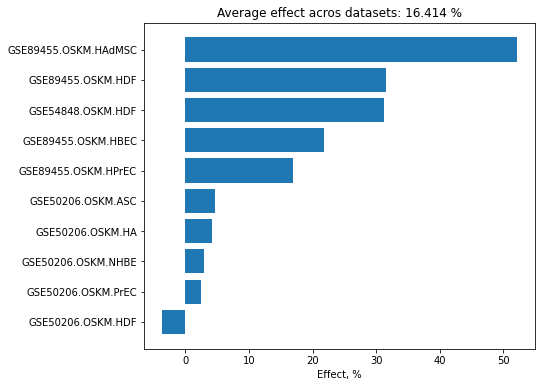

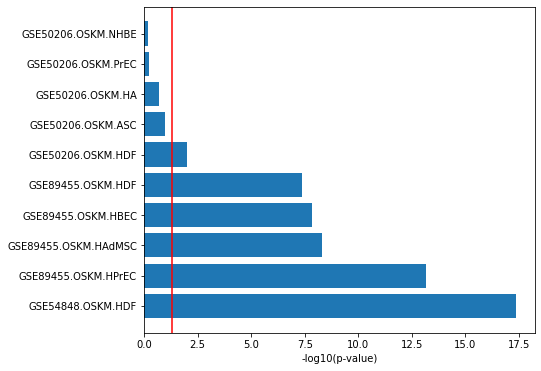

In [8]:
#plot significance of rejuvenation
D, M = list(zip(*[(k, v['max_effect']) for k,v in effects.items()])) #get pvals
D, M = list(zip(*[(x, y) for y,x in sorted(zip(M, D))])) #sort pvals

plt.figure(figsize=(7,6))
plt.barh(D, M)
plt.title('Average effect acros datasets: %.3f %%' % np.mean(M))
plt.xlabel('Effect, %')
plt.show()

#plot significance of rejuvenation
D, P = list(zip(*[(k, v['pval']) for k,v in effects.items()])) #get pvals
D, P = list(zip(*[(x, y) for y,x in sorted(zip(P, D))])) #sort pvals

thr = 0.05
plt.figure(figsize=(7,6))
plt.barh(D, -np.log10(P))
plt.axvline(-np.log10(thr), color='red')
plt.xlabel('-log10(p-value)')   
plt.show()

In [176]:
#bunch_effects = pd.DataFrame({"EMT":M, }, index=D)
# bunch_effects=bunch_effects.merge(pd.DataFrame({"Pluri":M, }, index=D), left_index=True, right_index=True)
# bunch_effects.melt().to_csv('clocks/human_group_effects.csv')

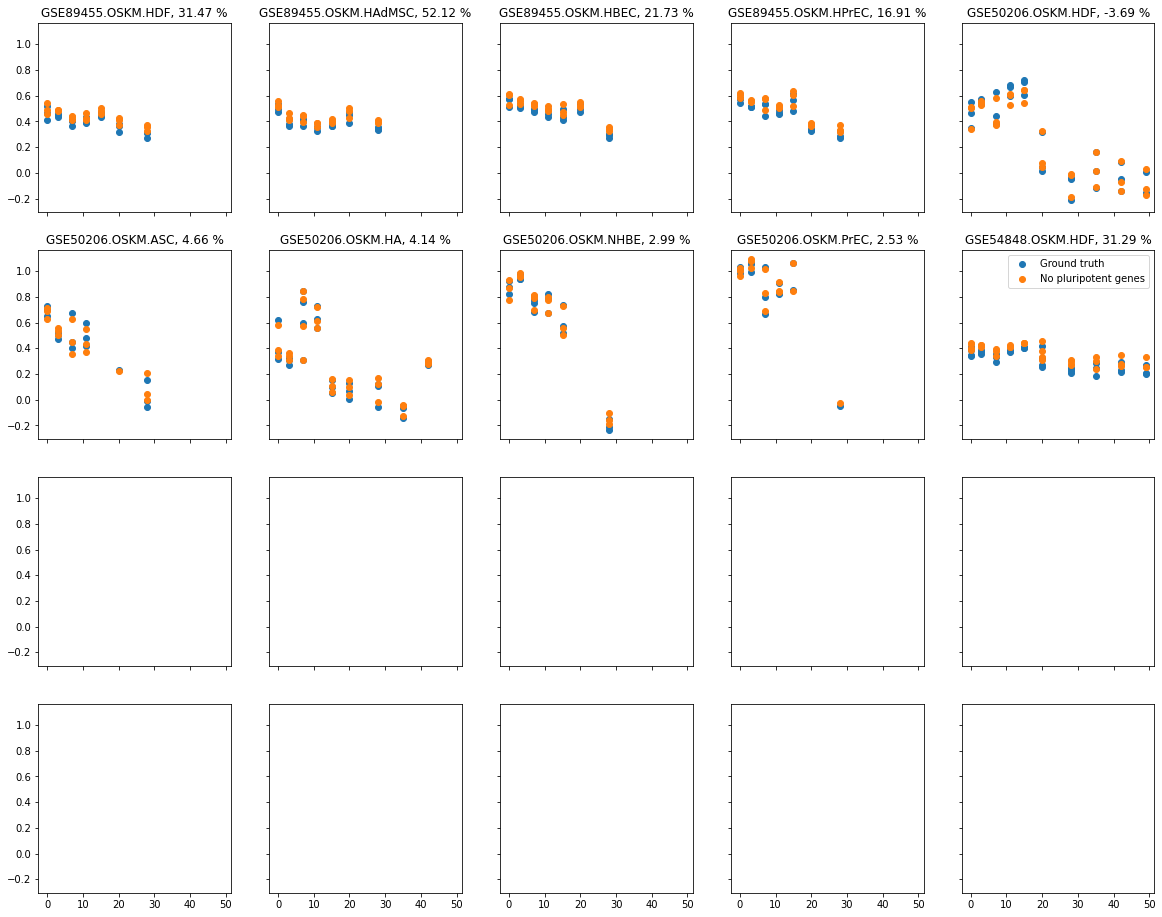

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)
for ax, (ds, v) in zip(axes.flatten(), effects.items()):
    sub_time = v['time']
    ground_pred = v['gnd']
    new_pred = v['npl']
    pval = v['pval']
    max_effect = v['max_effect']
    
    ax.set_title("%s, %s %%" % (ds, str(round(max_effect, 2))))
    ax.scatter(sub_time, ground_pred, label='Ground truth')
    ax.scatter(sub_time, new_pred, label='No pluripotent genes')
ax.legend()

In [61]:
#Check effects for all genes
approved_datasets = list(effects.keys())
gene_effects = pd.DataFrame()
for g in tqdm(wei.index.tolist()):
    knockout = [g]
    wei_tmp = wei.copy()
    wei_tmp.loc[knockout, 'coef'] = 0
    coef_modified = wei_tmp.coef.values
    itc = model.intercept_

    for ds in approved_datasets:
        sub_id = annot[annot.Dataset == ds].index
        sub_time = annot[annot.Dataset == ds].Time
        sub_data = data.loc[sub_id]
        sub_X = np.array(data.loc[sub_id][wei.etz.values])

        ground_pred = predict_tAge(sub_data, model)
        new_pred = np.dot(coef_modified, sub_X.T) + itc
        
        itc_m, slope_m, itc_p, slope_p, itc_e, slope_e, new_lm_pred = fit_lm(sub_time, new_pred - ground_pred)
        
        #compute effect
        ground_rej_effect = ground_effects[ds]
        knockout_rej_change = new_lm_pred[np.argmax(np.abs(new_lm_pred))]
        knockout_effect = knockout_rej_change / ground_rej_effect * 100

        gene_effects = gene_effects.append(pd.Series({"const":itc_m, "slope":slope_m, 
                                                      "p_const":itc_p, "p_slope":slope_p,
                                                      "e_const":itc_e, "e_slope":slope_e,
                                                      "dataset":ds, 'knockout_effect':knockout_effect}, 
                                                      name=g))

gene_effects['FDR_const'] = multipletests(gene_effects['p_const'] , 0.05, method='fdr_bh')[1]
gene_effects['FDR_slope'] = multipletests(gene_effects['p_slope'] , 0.05, method='fdr_bh')[1]
gef = gene_effects

In [45]:
# for ds in gef.dataset.unique():
#     su = gef[(gef.dataset==ds) & \
#             #((gef.pass_const==True) | (gef.pass_slope==True)) & \
#             (gef.const > 0)]

#     time = effects[ds]['time'].values
#     dt = max(time) - min(time)

#     #su['slope_effect'] = dt * su['slope']

#     print(ds, su.const.sum())#su.slope_effect.sum())

In [88]:
test_effects = pd.DataFrame()
for g in gef.index.unique():
    test = scipy.stats.ttest_1samp(gef.loc[g, 'knockout_effect'], popmean=0)
    #test = scipy.stats.wilcoxon(gef.loc[g, 'knockout_effect'])
    test_effects = test_effects.append(pd.Series({'pval':test.pvalue}, name=g))
test_effects['FDR'] = multipletests(test_effects['pval'], 0.05, method='fdr_bh')[1]
test_effects['star'] = test_effects['FDR'].apply(starfunc)

In [89]:
test_effects.sort_values('pval').iloc[:10,:]

,pval,FDR,star
Vrk2,0.000039,0.016462,*
C2cd2,0.000228,0.047832,*
Churc1,0.000498,0.058155,
Stc2,0.000648,0.058155,
Tfap2c,0.000692,0.058155,
Zfp9,0.001856,0.129927,
Eri1,0.003286,0.197171,
Synpo,0.004330,0.227350,
Pde4a,0.005428,0.243869,
Rragb,0.006918,0.243869,


In [79]:
gef['FDR'] = None
gef['star'] = None
for g in test_effects.index:
    gef.loc[g, 'FDR'] = test_effects.loc[g, 'FDR']
    gef.loc[g, 'star'] = test_effects.loc[g, 'star']

In [65]:
## SAVE BLOCK ##

#gef.to_csv('clocks/gene_effects.csv')
gef.to_csv('clocks/%s_gene_effects.csv' % species)
#gef = pd.read_csv('clocks/%s_gene_effects.csv' % species,index_col=0)

In [90]:
top_index = test_effects.sort_values('FDR').index[:15]
passed_genes = test_effects[test_effects.FDR < 0.05].index

In [91]:
gef['Tissue'] = gef.dataset.apply(lambda x: x.split('.')[-1])
gef['GSE'] = gef.dataset.apply(lambda x: x.split('.')[0])
gef.FDR = gef.FDR.apply(float)

In [16]:
#gef.to_csv('tmp/gefh.csv')

In [92]:
gef_passed = gef.loc[passed_genes]

In [93]:
gef_passed

,const,dataset,e_const,e_slope,knockout_effect,p_const,p_slope,slope,FDR_const,FDR_slope,FDR,star,Tissue,GSE
C2cd2,0.000729,GSE89455.OSKM.HBEC,0.000197,0.000013,0.195386,1.545675e-03,0.600409,-6.981769e-06,2.955873e-03,0.675385,0.047832,*,HBEC,GSE89455
C2cd2,0.000177,GSE89455.OSKM.HPrEC,0.000141,0.000009,0.205624,2.240466e-01,0.007353,2.800373e-05,2.786071e-01,0.016558,0.047832,*,HPrEC,GSE89455
C2cd2,0.000814,GSE50206.OSKM.HDF,0.000678,0.000026,0.204856,2.401437e-01,0.280470,-2.825773e-05,2.973039e-01,0.366400,0.047832,*,HDF,GSE50206
C2cd2,-0.000046,GSE50206.OSKM.ASC,0.001375,0.000096,0.116344,9.736299e-01,0.788693,2.619826e-05,9.785811e-01,0.834648,0.047832,*,ASC,GSE50206
C2cd2,0.001761,GSE50206.OSKM.HA,0.000644,0.000029,0.421884,1.107860e-02,0.228823,-3.576218e-05,1.798265e-02,0.311905,0.047832,*,HA,GSE50206
C2cd2,0.002735,GSE50206.OSKM.NHBE,0.000943,0.000068,0.216375,9.925175e-03,0.208203,-8.942904e-05,1.623592e-02,0.288837,0.047832,*,NHBE,GSE50206
C2cd2,-0.000157,GSE50206.OSKM.PrEC,0.000870,0.000080,0.271112,8.591718e-01,0.113243,1.359056e-04,8.850001e-01,0.174061,0.047832,*,PrEC,GSE50206
C2cd2,0.000210,GSE54848.OSKM.HDF,0.000139,0.000005,0.159732,1.397234e-01,0.917862,-5.562519e-07,1.833154e-01,0.936821,0.047832,*,HDF,GSE54848
Vrk2,0.003044,GSE89455.OSKM.HBEC,0.000266,0.000018,0.816044,5.590446e-10,0.000011,-1.038524e-04,3.348288e-09,0.000065,0.016462,*,HBEC,GSE89455
Vrk2,0.003056,GSE89455.OSKM.HPrEC,0.000364,0.000024,0.654082,8.097600e-08,0.002872,-8.263802e-05,3.216068e-07,0.007412,0.016462,*,HPrEC,GSE89455


In [94]:
gef_passed.index.unique().intersection(
['Cd44', 'Tgm2', 'Vim', 'Ccn2', 'Sfrp1', 'Pdlim4', 'Spp1', 'Fas', 'Col8a2', 
'Ecm1', 'Loxl1', 'Lama2', 'Comp', 'Postn', 'Fbn1', 'Mfap5', 
'Plaur', 'Col3a1', 'Col4a2', 'Ptx3', 'Ppib', 'Il6', 'Edil3', 'Lox', 'Col6a3', 
'Serpine1', 'Col5a1', 'Col4a1', 'Fbn2', 'Fbln2', 'Wipf1'])

Index([], dtype='object')

In [52]:
#test_effects.loc[top_gef.index.unique()]

In [79]:

#gef['Tissue'] = gef['Tissue'].apply(lambda x: )

In [99]:
gef_passed.groupby(gef_passed.index)['knockout_effect'].mean()

C2cd2    0.223914
Vrk2     0.772876
Name: knockout_effect, dtype: float64

Text(0, 0.5, 'Effect of age increasing by knock-out, %')

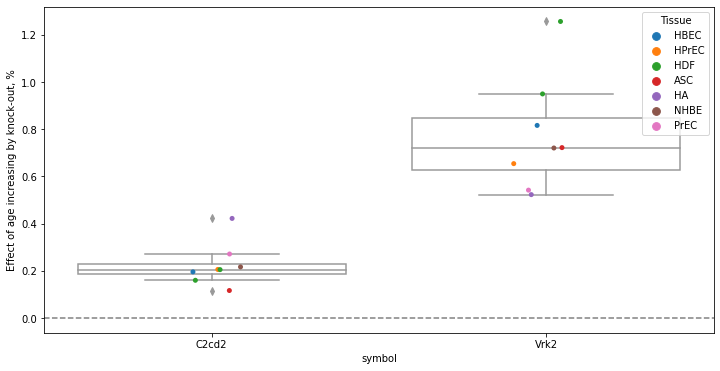

In [102]:
top_index = gef_passed.groupby(gef_passed.index)['knockout_effect'].mean().index#.sort_values(ascending=False)#[1:15].index
# top_index = gef_passed.groupby(gef_passed.index)['p_const'].apply(lambda x: np.exp(np.mean(np.log(x)))).\
#                         sort_values(ascending=True)[1:15].index
top_gef = gef_passed.loc[top_index]
top_gef['symbol'] = top_gef.index

plt.figure(figsize=(12,6))
ax = sns.boxplot(x='symbol', y='knockout_effect', data=top_gef, color='white')
sns.stripplot(x='symbol', y='knockout_effect', data=top_gef, hue='Tissue', ax=ax)
ax.axhline(0, ls='--', c='grey')
ax.set_ylabel('Effect of age increasing by knock-out, %',)

# for xtick in ax.get_xticks():
#     ax.text(xtick, medians[xtick] + vertical_offset, edians[xtick], 
#             horizontalalignment='center',size='x-small',color='w',weight='semibold')


In [52]:
test_effects.loc[top_gef.index.unique()]

,pval,FDR,star
Ezh2,0.000061,0.000438,***
Cd24a,0.000061,0.000438,***
Rps4l,0.018066,0.041989,*
Col4a1,0.000854,0.003130,**
Fn1,0.000122,0.000697,***
Snhg11,0.000854,0.003130,**
Clec7a,0.005371,0.016018,*
Col1a2,0.000061,0.000438,***
Igfbp4,0.000854,0.003130,**
Postn,0.021545,0.047768,*


In [459]:
#gef.groupby(gef.index)['const'].mean().sort_values(ascending=False)[1:10]

In [53]:
#su.sort_values('const')
#построить средние эффекты генов по различным датасетам (можно в виде боксплота с точками)

# Compare Human and Mouse

In [104]:
gefh = pd.read_csv('clocks/human_gene_effects.csv',index_col=0)
gefm = pd.read_csv('clocks/mouse_gene_effects.csv',index_col=0)
gefm['species'] = 'mouse'
gefh['species'] = 'human'

In [114]:
isec = gefh.index.intersection(gefm.index).unique()
isec

Index(['Gpnmb', 'Vim', 'Cpeb2', 'Ddit4', 'Rhoq', 'Efemp1', 'Anxa4', 'Bhlhe40',
       'Ahnak', 'S100a6', 'Smyd2', 'Tbc1d1', 'Hs3st3b1', 'Postn', 'Ier3',
       'Col3a1', 'Ddx3y', 'Slc9a3r2', 'Notch3', 'Zfp36', 'Plk2', 'Dhcr24',
       'Egr1', 'Col4a1', 'Nrep'],
      dtype='object')

In [142]:
glob = pd.concat([gefm.loc[isec][['knockout_effect', 'species']], gefh.loc[isec][['knockout_effect', 'species']]])
glob = glob.reset_index()
glob.columns = ['genes', 'knockout_effect', 'species']

In [164]:
test_effects = pd.DataFrame()
for s in glob.species.unique():
    for g in glob.genes.unique():
        test = scipy.stats.ttest_1samp(glob[glob.species==s][glob.genes==g]['knockout_effect'], popmean=0)
        #test = scipy.stats.wilcoxon(gef.loc[g, 'knockout_effect'])
        test_effects = test_effects.append(pd.Series({'pval':test.pvalue, "species":s}, name=g))
test_effects['FDR'] = multipletests(test_effects['pval'], 0.05, method='fdr_bh')[1]
test_effects['star'] = test_effects['FDR'].apply(starfunc)

In [165]:
test_effects

,pval,species,FDR,star
Gpnmb,5.713912e-01,mouse,6.802276e-01,
Vim,2.493137e-07,mouse,4.155228e-06,***
Cpeb2,7.913242e-01,mouse,8.601350e-01,
Ddit4,1.048096e-08,mouse,5.240481e-07,***
Rhoq,1.816966e-05,mouse,1.475804e-04,***
Efemp1,1.653688e-01,mouse,3.307376e-01,
Anxa4,2.468227e-02,mouse,7.259490e-02,
Bhlhe40,2.361286e-05,mouse,1.475804e-04,***
Ahnak,2.065376e-03,mouse,8.605735e-03,**
S100a6,9.762743e-08,mouse,2.440686e-06,***


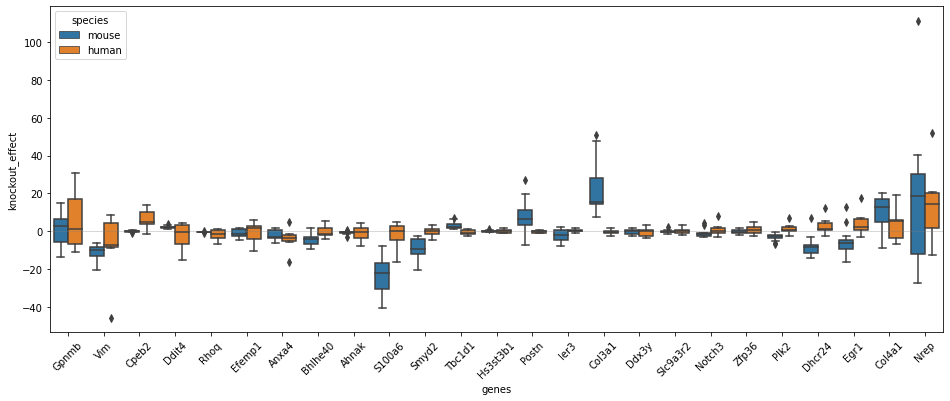

In [151]:
plt.figure(figsize=(16,6))
sns.boxplot(x='genes', y='knockout_effect', hue='species', data=glob)
plt.axhline(0, lw=0.5, alpha=0.6, color='grey')
plt.xticks(rotation=45)
plt.show()

# Check drug effects